In [1]:
import sys
sys.path.append('/Users/tristanbilot/Desktop/Desktop/EPITA/S8/Cryptology/project')
from typing import Callable, Union, List
from pyDes import des
from random import random
from matplotlib import pyplot as plt
import math

## Cryptographic analysis of DES algorithm
#### I.   Find patterns from x0  
#### II.  Find patterns from the encryption key   
#### III. Analysis of the ASCII letters using ASCII incrementation or translation  
#### IV.  Benchmark  
#### V.   Conclusion

The constructor of the DES object has been modified in order to modify the number of turns of the encryption algorithm.

In [12]:
key = "xyxyxyxy"
algo = des(key, 3) # 3 is the number of turns of the DES encryption algorithm

## Hands-on encrypt function
### Compare length
This test shows us that the length of the output of the encrypt function depends on the length of the input.
The input has to be be a modulo of 8. For each input of size n, the encrypted output is of the same size (x2 because of the hexa form).<br>
**==> DES uses a 56bit key for encryption.**

In [3]:
"""
Compares the output lengths of the encrypt function.
"""
for i in range(1, 5):
    s = 'aaaaaaaaaaaaaaaaaaaaaaaa' * i
    print(f'{len(s)} - {len(algo.encrypt(s))}')

24 - 24
48 - 48
72 - 72
96 - 96


### Compare encrypted value
Now, by comparing the actual output of the encrypt function.<br>
Let's create a variable 'a' and 'b' is the DES of a, then we see that **if DES(a) = b, then, DES(aa) = bb**.

In [4]:
"""
The DES of the concatenation of a same variable is the concatenation of the DES of this variable.
"""
for i in range(1, 3):
    s = 'aaaaaaaa' * i
    print(f'{s} - {algo.encrypt(s).hex()}')

aaaaaaaa - dfcae27fb190d12b
aaaaaaaaaaaaaaaa - dfcae27fb190d12bdfcae27fb190d12b


## I. Find patterns from x0 (the initial value)
## Using Floyd algorithm to analyse DES
- Distance of different bits
- Distance of different characters
- Distance of longest common substring

In [5]:
def f(data: Union[int, str]) -> Union[int, str]:
    """
    Function used to encrypt in DES.
    """
    return algo.encrypt(data)

In [6]:
"""
Utils.
"""
def pad_and_encrypt(data: Union[int, str]) -> bytes:
    """
    Takes an integer or str as input, pad it to 8 bytes and encrypt it
    using the DES object.
    """
    if type(data) is int:
        data = (data).to_bytes(8, byteorder='big')
    return algo.encrypt(data)

def encrypt_with_key(data: Union[int, str], key: str) -> bytes:
    """
    Encrypt with DES using data and key.
    """
    algo = des(key)
    return algo.encrypt(data)

def bytes_to_binary(data: bytes):
    """
    Converts bytes to binary number.
    """
    return bin(int(pad_and_encrypt(data).hex(), base=16))

def dump_encrypt_values(data: int):
    """
    Displays the encrypted values (hex and bin) of an input.
    The input should be a non-encrypted value.
    """
    print(f'{data}:')
    data = pad_and_encrypt(data)
    print(f'\thex: {data.hex()}')
    print(f'\tbin: {bytes_to_binary(data)}')

def dump_encrypt_key(data: str, key: str):
    """
    Displays the encrypted values (hex and bin) of an input.
    The input should be a non-encrypted value.
    """
    print(f'{key}:')
    data = encrypt_with_key(data, key)
    print(f'\thex: {data.hex()}')
    print(f'\tbin: {bytes_to_binary(data)}')

def plot(histogram: List):
    """
    Used to plot histograms.
    """
    plt.xlabel('distance')
    plt.ylabel('occurences')
    plt.hist(histogram)

The actual floyd algorithm implementing the "Lievre et la tortue" version to find an approached cycle in the encryptions of values generated itiratively by the function f.

In [7]:
def floyd(
    distance_fn: Callable, 
    f: Callable, 
    x0: object, 
    delta: int,
    max_iter: int=math.inf,
    verbose: int=True
    ):
    """
    "Lievre et la tortue" algorithm to compute an approached cycle 
    based on the DES encryption algorithm.

    Parameters:
    ----------
    distance_fn: Callable
        The distance function used as stop condition for the loop.
    f: Callable
        The iterative function used to generate new data from `x0`.
    x0: object
        Object used as first item for the generation of samples to encrypt.
        It can be int, str... but `distance_fn` should handle the type of delta.
    delta: int
        The value used to stop the loop when compared to the distance function.
    """
    m = 1
    histogram = []
    tortue = f(x0)
    lievre = f(f(x0))
    if None in [tortue, lievre]:
        return [len(x0)]
    dist = distance_fn(pad_and_encrypt(tortue), pad_and_encrypt(lievre))

    while (dist > delta or lievre == tortue) and m <= max_iter:
        m = m + 1

        tortue = f(tortue)
        lievre = f(f(lievre))
        if tortue is None or lievre is None:
            break
        if lievre == tortue:
            continue

        dist = distance_fn(pad_and_encrypt(tortue), pad_and_encrypt(lievre))
        histogram.append(dist)

    if verbose:
        if m <= max_iter and not (tortue is None or lievre is None):
            print(f'\n[+] Found - number of differences: {dist}')
            dump_encrypt_values(lievre)
            dump_encrypt_values(tortue)
            print(f'iteration: {m}')
        else:
            print(f'No solution found in reasonable time. ({max_iter} iter)')
    return histogram

## 1. Bit distance
The first implementation use the well known Hamming distance on each pairs of encrypted values in order to find pairs with little distances, meaning that we could find similar patterns using differents inputs.

In [8]:
def bit_distance(a, b):
    """
    Computes the number of different bits between bytes a & b.
    """
    a = int.from_bytes(a, 'big')
    b = int.from_bytes(b, 'big')
    return bin(a ^ b).count('1')

assert bit_distance(b'\x08', b'\x04') == 2
assert bit_distance(b'\x02', b'\x02') == 0

The following example **finds a pair of ciphered values where the number of different bits is <= 18.**<br>
In a reasonable time, pairs containing 15 or 16 different bits can be found (ex: 9777 and 9602)


[+] Found - number of differences: 16
b'\xe2\xe0\n\xa3\xdd\xe9\x00G':
	hex: 229084a3dd398831
	bin: 0b100100101000111110110001100111011001101100010100111110110100111
b'G\xc9X\xfb\xb9\xd2H\xff':
	hex: 2b90c063e5bd9c22
	bin: 0b1101000001100001111000000000010000001110001111100101101111000
iteration: 2114


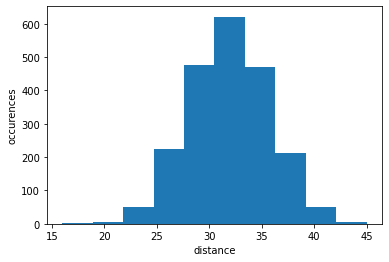

In [9]:
distance_fn = bit_distance
delta = 16
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f, x0, delta)
plot(histogram)

## 2. Distance of different characters
This distance algorithm computes the number of different characters between the two ciphered messages.
Considering that the messages are 8-bytes long, it is really hard to find pairs with more than 2 common bytes (the function returns a value < 6). So we do not got nice results using this method.

In [10]:
def char_distance(a, b):
    """
    Computes the number of different characters between the 2 bytes objects a & b.
    Run over the two 8-bytes hex objects and perform comparison 2 bytes by 2 bytes.
    """
    a = a.hex()
    b = b.hex()
    assert len(a) % 8 == 0 and len(b) % 8 == 0
    d = 0
    for i in range(len(a) // 2):
        i = i * 2
        if a[i: i+2] != b[i: i+2]:
            d += 1
    return d

assert char_distance(b'abcaazer', b'adqaazer') == 2
assert char_distance(b'abcdefgb', b'abcdefgb') == 0

The following example shows a 6-bytes difference between a pair (177 and 625). Looking for pairs with less than 6 different bytes has not been possible in reasonable time.


[+] Found - number of differences: 6
b'\xd1\x81\x87@\x98\xae}n':
	hex: f9baab5575acba30
	bin: 0b1001010010100010011110101100010100000110110111110011110110110
b'p\xc8\xf9+|$\xd4\xac':
	hex: 8ff0ab3f75233559
	bin: 0b1111100100100110111100011101100110100110011001000011010100100000
iteration: 1217


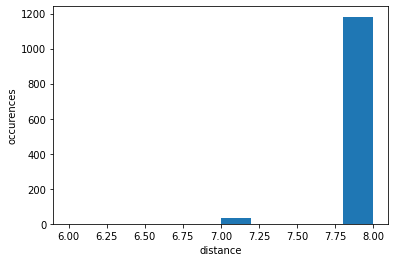

In [11]:
distance_fn = char_distance
delta = 6
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f, x0, delta)
plot(histogram)

## 3. Distance of longest common substring
The following algorithm compute the number of characters that are not in the longest common substring of each pair traversed by the main loop. So it allows us to check whether a similar pattern is discovered among different values.<br>
The max lcs computed in reasonable time in of **size 3** (delta = 8-3=5) with the values 58859 and 29437.

> Note: The recursive version of LCS has been tested but does not work for strings > 8 bytes because of calls stack.

In [12]:
def lcs_distance(a, b, verbose: bool=False) -> int:
    """
    Returns the number of characters that are not in the longest substring between a and b.
    Ex: lcs_distance('abc', 'abd') == 1 because the lcs is 'ab' and the number of remained
    charcaters is only 1.
    """
    assert len(a) % 8 == 0 and len(b) % 8 == 0

    la, lb = len(a), len(b)
    maxL, end = 0, la
    dp = [[0 for x in range(lb + 1)] for y in range(la + 1)]
 
    for i in range(1, la + 1):
        for j in range(1, lb + 1):
            if a[i - 1] == b[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > maxL:
                    maxL = dp[i][j]
                    end = i

    lcs = a[end - maxL: end]
    dist = len(a) - len(lcs)
    
    if verbose:
        print(lcs)
        return lcs, dist
    return dist

assert lcs_distance('abcpoiuy', 'abcmlkjh') == 8 - 3
assert lcs_distance('xsmtreop', 'amtreqze') == 8 - 4

We found LCS=2 for key="AAAAAAAA" and LCS=3 for key="xyxyxyxy"

No solution found in reasonable time. (10000 iter)


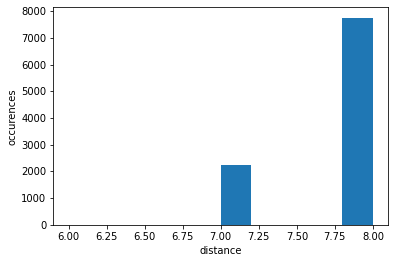

In [13]:
distance_fn = lcs_distance
delta = 4
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f, x0, delta, max_iter=10000)
plot(histogram)

### Match: found a pattern in the LCS
When using keys of the form xyxyxyxy and yxyxyxyx we figure that the LCS are the same.  

In [14]:
# POC
def lcs_floyd(data: str, key: str, delta: int, max_iter: int):
    """
    Proof that a word ciphered with xyxyxyxy or yxyxyxyx gives the same LCSs.
    """
    m = 1
    k = des(key)
    tortue = k.encrypt(data)
    lievre = k.encrypt(tortue)
    _, dist = lcs_distance(tortue.hex(), lievre.hex(), verbose=True)
    dist = len(data) - dist
    history = []

    while dist <= delta and m <= max_iter:
        m = m + 1
        tortue = k.encrypt(tortue)
        lievre = k.encrypt(k.encrypt(lievre))
        _, dist = lcs_distance(tortue.hex(), lievre.hex(), verbose=True)
        dist = len(data) - dist
        history.append(dist)
    return history

data = "aozpengh"
a = lcs_floyd(data, "xyxyxyxy", 5, 5)
print('=====')
b = lcs_floyd(data, "yxyxyxyx", 5, 5)
assert a == b

a3
ae
8d
0
0a
a7
=====
a3
ae
8d
0
0a
a7


## 4. Tests using letter alterations (xy => xz...)
### Letters incrementation
This algorithm tries to find patterns when generating strings following this schema:<br>
**aaaa => abab => acac => ... => azaz => bzbz => ... => zzzz**<br>
But when the size of the generated strings is greater than 16, the algorithm does not respond anymore, because of too long calculations. Briefly, the max delta used for this algorithm is 7 so it is a really bad result.

In [2]:
def f_str_increm(data: str, verbose: bool=False, double_if_max: bool=True) -> str:
    """
    Iterative function which generates a string following this schema:
    aaaa => abab => acac => ... => azaz => bzbz => ... => zzzz
    When arrived to zzzz...z, return aaaa...a of size len(data) * 2.
    """
    if data is None:
        return None

    assert len(data) >= 2 and len(data) % 2 == 0
    assert 'a' <= data[0] <= 'z' and 'a' <= data[1] <= 'z'

    # checks whether the str is full of 'z's, then double with 'a's.
    if data[0] == 'z' and len(set(data)) == 1:
        if double_if_max:
            return ''.join('a' * (len(data) * 2))
        return None

    # handle aaaa => abab
    newList = list(data)
    find_z = data[1] == 'z'
    off = 0 if find_z else 1
    newChar = chr(ord(data[off]) + 1)
    permutations = [i * 2 + off for i in range(len(data) // 2)]

    for p in permutations:
        newList[p] = newChar

    # handle azaz => baba
    if find_z:
        permutations = [i * 2 + 1 for i in range(len(data) // 2)]
        newChar = 'a'
        for p in permutations:
            newList[p] = newChar

    res = ''.join(newList)
    if verbose:
        print(res)
    return res

def f_str_increm_no_double(data: str, verbose: bool=False) -> str:
    return f_str_increm(data, verbose, False)

In [3]:
"""
Test of f_str_increm iterative function.
"""
seed = "aaaaaaaa"
for _ in range(10):
    seed = f_str_increm(seed, True)

abababab
acacacac
adadadad
aeaeaeae
afafafaf
agagagag
ahahahah
aiaiaiai
ajajajaj
akakakak



[+] Found - number of differences: 0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa:
	hex: dfcae27fb190d12bdfcae27fb190d12bdfcae27fb190d12bdfcae27fb190d12b
	bin: 0b1011001000111111101111100111010101101110011111001100010001110011101100100011111110111110011101010110111001111100110001000111001110110010001111111011111001110101011011100111110011000100011100111011001000111111101111100111010101101110011111001100010001110011
aaaaaaaaaaaaaaaa:
	hex: dfcae27fb190d12bdfcae27fb190d12b
	bin: 0b10110010001111111011111001110101011011100111110011000100011100111011001000111111101111100111010101101110011111001100010001110011
iteration: 676


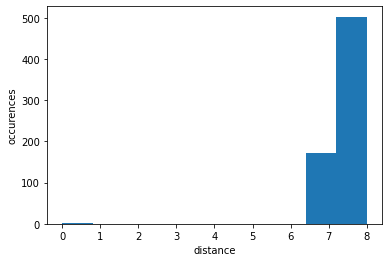

In [ ]:
distance_fn = lcs_distance
delta = 6
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_increm, x0, delta)
plot(histogram)

### Letters random subsitution with alphabet letters
This implementation randomly substitute letters in the string with random alphabet letters. We expected to have better results than the previous attempt using letter incrementations because of the fixed size (not doubling the size when all cases are reached) but the program also does not respond after reaching the 16 bytes string length.<br>
However, **we achieved a lcs of size 2** which means a delta=6 (8-2=6) in few seconds ('xfxfxfxf' and 'imimimim' in 534 iterations).<br>
 **In short time, no solution is possible for delta<6 with string pairs of size 8 bytes.**

In [ ]:
import string

def f_str_rand(data: str, verbose: bool=False) -> str:
    """
    Iterative function which generates a string following a random schema.
    The letter subsitution is done with an offset of 1 char.
    Ex: aaaa => aqaq => sqsq => wqwq => ...
    """
    assert len(data) >= 2 and len(data) % 2 == 0
    assert 'a' <= data[0] <= 'z' and 'a' <= data[1] <= 'z'

    newList = list(data)
    off = round(random())
    permutations = [i * 2 + off for i in range(len(data) // 2)]

    abc = string.ascii_lowercase
    rd = round(random() * (26 - 1))
    rd_char = abc[rd]

    for p in permutations:
        newList[p] = rd_char

    res = ''.join(newList)
    if verbose:
        print(res)
    return res

In [ ]:
"""
Test of f_str_rand iterative function.
"""
seed = "aaaaaaaa"
for _ in range(10):
    seed = f_str_rand(seed, True)

rararara
xaxaxaxa
vavavava
kakakaka
kckckckc
scscscsc
gcgcgcgc
gsgsgsgs
rsrsrsrs
lslslsls



[+] Found - number of differences: 6
sksksksk:
	hex: 2188e1c8c9c2bde8
	bin: 0b1011111010000100011001100001111000101010111110111011100011011111
ynynynyn:
	hex: 4bee84472188eb42
	bin: 0b1100101100101111111100100100010101010001100011011010101110101010
iteration: 11


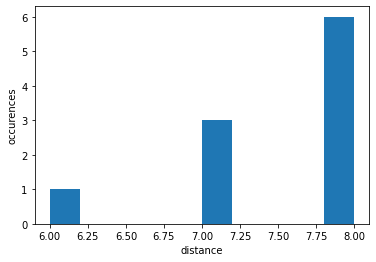

In [ ]:
distance_fn = lcs_distance
delta = 6
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_rand, x0, delta)
plot(histogram)

## 5. Applying all the previous algorithms with schema xyxy (random & increment)
Some of the first algorithms (bit_distance, char_distance) used x0 as a number for testing purpose, now we are interested to test with string using the schema aaaa => abab => ... => azaz.

### Char distance with string incrementation (aaaa => abab => ... => azaz)
The first test finished as expected to the following pair:  
- **str**: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
    - **encrypted**: 20e3f711dd4d650b20e3f711dd4d650b20e3f711dd4d650b20e3f711dd4d650b  
    
- **str**: aaaaaaaaaaaaaaaa 
    - **encrypted**: 20e3f711dd4d650b20e3f711dd4d650b
    
As the short string is contained in the long one, the algorithm stops with a char difference of 0 (delta=0).


[+] Found - number of differences: 0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa:
	hex: dfcae27fb190d12bdfcae27fb190d12bdfcae27fb190d12bdfcae27fb190d12b
	bin: 0b1011001000111111101111100111010101101110011111001100010001110011101100100011111110111110011101010110111001111100110001000111001110110010001111111011111001110101011011100111110011000100011100111011001000111111101111100111010101101110011111001100010001110011
aaaaaaaaaaaaaaaa:
	hex: dfcae27fb190d12bdfcae27fb190d12b
	bin: 0b10110010001111111011111001110101011011100111110011000100011100111011001000111111101111100111010101101110011111001100010001110011
iteration: 676


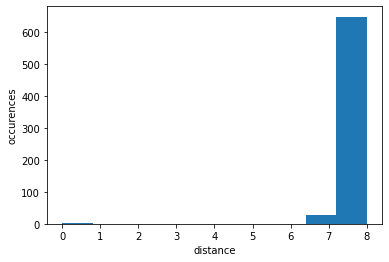

In [ ]:
distance_fn = char_distance
delta = 6
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_increm, x0, delta)
plot(histogram)

### Char distance with string random generation (aaaa => afaf => ... => mpmporor ...)
Concerning the random generation of this pattern, we do not achieve better results than with x0 as an integer.  
Dela=6 is doable in few milliseconds but Delta=5 (3 common bytes) gives no great results.


[+] Found - number of differences: 6
qoqoqoqo:
	hex: 4fc8c6ff349a46eb
	bin: 0b1010100000010110100110110000100101111100101000101101001111011
dgdgdgdg:
	hex: 4a9d32ffedf546e2
	bin: 0b1010101110000011011111100101011001110110100001110001011100110000
iteration: 3919


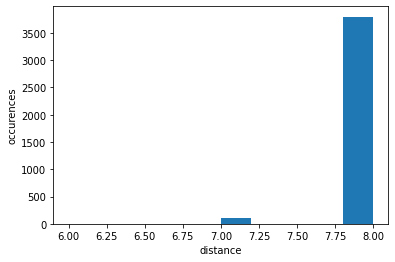

In [ ]:
distance_fn = char_distance
delta = 6
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_rand, x0, delta)
plot(histogram)

### Bit distance with string incrementation (aaaa => abab => ... => azaz)
The bit distance with string incrementation gives no intersting results with a delta < 22 in doable time.


[+] Found - number of differences: 21
cycycycy:
	hex: 5725fb90507b0fe5
	bin: 0b1111101100100000111001010100001011111000110101011100011100001
bmbmbmbm:
	hex: 1791f3d5812727a7
	bin: 0b1111101111010010111010110000101011100001011110000001100010000
iteration: 38


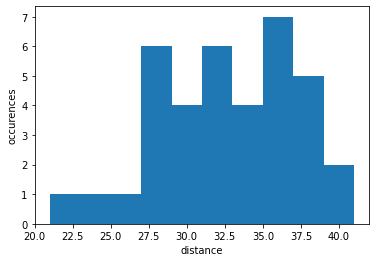

In [ ]:
distance_fn = bit_distance
delta = 22
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_increm, x0, delta)
plot(histogram)

### Bit distance with string random generation (aaaa => afaf => ... => mpmporor ...)  
Using this implementation, we can find pairs containing only 15/64 different bits (found in 2s-8k iterations) or even 14bits.


|   Str 1  |   Str 2  | Different bits |  Iter | Time (s) |
|:--------:|:--------:|:--------------:|:-----:|:--------:|
| vrvrvrvr | gpgpgpgp |       15       | 8563  |    ~2s    |
| gtgtgtgt | mqmqmqmq |       14       | 31172 |    ~300s    |


[+] Found - number of differences: 17
sqsqsqsq:
	hex: b4abdb096f1762fe
	bin: 0b1111011001011001000111001111101111011101110100110010001001111110
hehehehe:
	hex: a09ad151ef1f32aa
	bin: 0b111100101011010101011110110110110010111001100001011011111011000
iteration: 1505


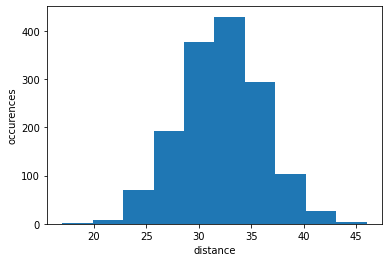

In [ ]:
distance_fn = bit_distance
delta = 18
x0 = "aaaaaaaa"
histogram = floyd(distance_fn, f_str_rand, x0, delta)
plot(histogram)

## II. Find patterns from the encryption key  
No intersting patterns nor cycles has been found during the previous exploration using the x0 seed. It could be interesting now to apply these algorithms on the key instead of x0.

First of all, let's define a new floyd function that takes in input x0 and an initial key.

In [ ]:
def floyd_with_key(
    distance_fn: Callable, 
    f: Callable, 
    x0: str,
    key: str,
    delta: int,
    max_iter: int,
    verbose: bool=True,
    ):
    """
    Same function as the first one except that the DES object is recreated
    at each loop with a new key.
    """
    m = 1
    histogram = []
    tortue = f(key)
    lievre = f(f(key))
    if tortue is None or lievre is None:
        return [len(key)]
    dist = distance_fn(encrypt_with_key(x0, lievre), encrypt_with_key(x0, tortue))

    while (dist > delta or lievre == tortue) and m <= max_iter:
        m = m + 1

        tortue = f(tortue)
        lievre = f(f(lievre))
        if tortue is None or lievre is None:
            break
        if lievre == tortue:
            continue

        dist = distance_fn(encrypt_with_key(x0, lievre), encrypt_with_key(x0, tortue))
        histogram.append(dist)

    if verbose:
        if m <= max_iter and not (tortue is None or lievre is None):
            print(f'\n[+] Found - number of differences: {dist}')
            dump_encrypt_key(x0, lievre)
            dump_encrypt_key(x0, tortue)
            print(f'iteration: {m}')
        else:
            print(f'No solution found in reasonable time. ({max_iter} iter) (min dist: {dist}')
    return histogram

### First match! Bit distance for 8 Bytes key
When using randomly generated strings, we finally find a match!  
> The pattern found is the pair (abab, bbbb).  
> It means that each pair following this pattern will have the same encrypted value! What a discovery.  
Example of found pair: (eaeaeaea, dadadada) => b6a24204afa82366

In [ ]:
distance_fn = bit_distance
delta = 0
x0  = "aaaaaaaa"
key = "aaaaaaaa"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_rand, x0, key, delta, max_iter)


[+] Found - number of differences: 0
ilililil:
	hex: 02fd5b3b7ce492dc
	bin: 0b101111011011111100111010101101111010110110000111000000100000011
imimimim:
	hex: 02fd5b3b7ce492dc
	bin: 0b101111011011111100111010101101111010110110000111000000100000011
iteration: 78


### Proof of concept
Proof that the following discovery works:

In [ ]:
x0 = "yhtmlsrguipdbnqj"

key = "eaeaeaea"
algo = des(key)
a = algo.encrypt(x0)

key = "dadadada"
algo = des(key)
b = algo.encrypt(x0)

print(bit_distance(a, b))
print(b.hex())
print(a.hex())

0
05ef5892e81d7478af100b4ddbba311d
05ef5892e81d7478af100b4ddbba311d


> Thus, we know that every test will have a score of 8/8 because the found match is exactly the same.

### Match: Char distance for 8 Bytes key
A match is found following the same schema.


[+] Found - number of differences: 0
ixixixix:
	hex: 669d4780e73d01e6
	bin: 0b1100011101001101111100101100100010001110100111001100110100000100
iyiyiyiy:
	hex: 669d4780e73d01e6
	bin: 0b1100011101001101111100101100100010001110100111001100110100000100
iteration: 60


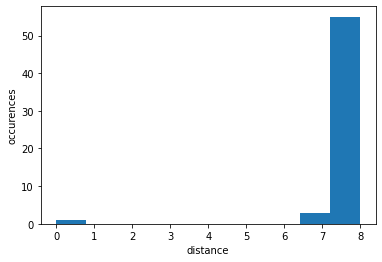

In [ ]:
distance_fn = char_distance
delta = 6
x0 = "yejansgx"
key = "tehfdnps"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_rand, x0, key, delta, max_iter)
plot(histogram)

### Match: LCS distance for 8 Bytes key



[+] Found - number of differences: 0
ryryryry:
	hex: b9884cf84894f9e4
	bin: 0b1000001011110110110111000001001100101110000000111100000101001111
sysysysy:
	hex: b9884cf84894f9e4
	bin: 0b1000001011110110110111000001001100101110000000111100000101001111
iteration: 99


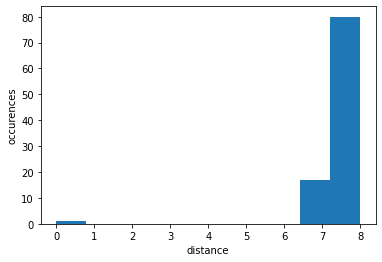

In [ ]:
distance_fn = lcs_distance
delta = 6
x0 = "yejansgx"
key = "tehfdnps"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_rand, x0, key, delta, max_iter)
plot(histogram)

## III. Analysis of the ASCII letters using ASCII incrementation or translation
This approach will use separately the ASCII letters of the strings and offset them by one iteratively in order to find a possible pattern.  
**Schema:** abcd => bcde => ... => zzzz

In [ ]:
def f_str_ascii_increment(data: str, right: bool, verbose: bool=False) -> str:
    """
    Iterative function which generates an ASCII letter incrementation.
    Ex: abcd => bcde => ... => zzzz
    `right` = True => right translation
    `right` = False => left translation
    """
    if data is None or \
        (right and data.find('z') != -1) or \
        (not right and data.find('a') != -1):
        return None

    off = 1 if right else -1
    newList = list(map(lambda x: chr(ord(x) + off), data))
    res = ''.join(newList)
    if verbose:
        print(res)
    return res

assert f_str_ascii_increment('abcd', True) == 'bcde'
assert f_str_ascii_increment('yyyy', True) == 'zzzz'
assert f_str_ascii_increment('bcde', False) == 'abcd'

In [ ]:
"""
Wrappers for left and right incrementation.
"""

def f_str_ascii_right_increment(data: str, verbose: bool=False) -> str:
    return f_str_ascii_increment(data, True, verbose)

def f_str_ascii_left_increment(data: str, verbose: bool=False) -> str:
    return f_str_ascii_increment(data, False, verbose)

### ASCII right incrementation with LCS distance
Using ASCII incrementation of all letters, no pattern is found.

No solution found in reasonable time. (10000.0 iter) (min dist: 7


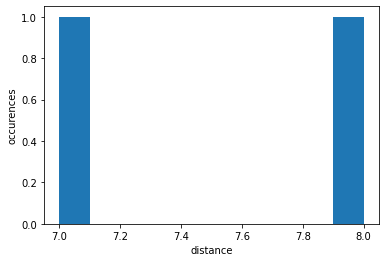

In [ ]:
distance_fn = lcs_distance
delta = 6
x0 = "yejansgx"
key = "tehfdnps"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_ascii_right_increment, x0, key, delta, max_iter)
plot(histogram)

### ASCII right incrementation with char distance
No pattern found.

No solution found in reasonable time. (10000.0 iter) (min dist: 8


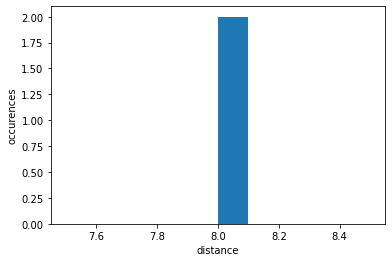

In [ ]:
distance_fn = char_distance
delta = 6
x0 = "yejansgx"
key = "tehfdnps"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_ascii_right_increment, x0, key, delta, max_iter)
plot(histogram)

### ASCII right incrementation with Bit distance
No pattern found.

No solution found in reasonable time. (10000.0 iter) (min dist: 28


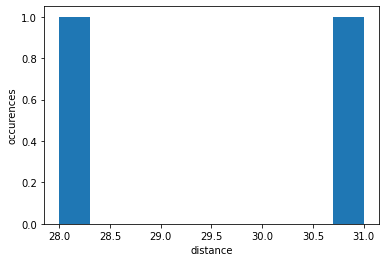

In [ ]:
distance_fn = bit_distance
delta = 16
x0 = "yejansgx"
key = "tehfdnps"
max_iter = 1e4
histogram = floyd_with_key(distance_fn, f_str_ascii_right_increment, x0, key, delta, max_iter)
plot(histogram)

## IV. Benchmark
This is the final step: the total benchmarking of all the methods.  
It can be seen as a bruteforce of all the previous methods.  
We previously tested some implementations but now we're gonna use them all and compare them using a graph representation.
> Goal: combine all the previous algorithms to find the one with the best results.

### Benchmark on x0

In [ ]:
def benchmark_x0(x0: str, delta: int, max_iter: int):
    """
    Use floyd() on all possible combinations of distance 
    and iterative functions.
    """
    distance_funcs = {
        'bit_dist': bit_distance,
        'char_dist': char_distance,
        'lcs_dist': lcs_distance,
    }
    iterative_funcs = {
        'encrypt': f,
        'increm': f_str_increm_no_double,
        'random': f_str_rand,
        'ascii_right': f_str_ascii_right_increment,
        'ascii_left': f_str_ascii_left_increment,
    }
    histograms = []

    for dist_str, dist in distance_funcs.items():
        for ite_str, ite in iterative_funcs.items():
            operation_str = f'{dist_str}-{ite_str}'
            hist = floyd(dist, ite, x0, delta, max_iter, False)
            histograms.append((operation_str, hist))

    def get_default_value(name, x0):
        return len(x0) if name.find('bit') == -1 else len(x0)**2

    best_results = [min(hist, default=get_default_value(name, x0)) \
        for name, hist in histograms]
    best_names = [name for name, _ in histograms]
    return (best_results, best_names)

In [ ]:
def plot_horizontal_histogram(values, labels, title):
    """
    Plots an horizontal histogram with labels.
    """
    fig, ax = plt.subplots(figsize =(16, 9))
    ax.barh(best_names, best_results)
    
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    ax.invert_yaxis()
    for i in ax.patches:
        plt.text(i.get_width() + 0.2, i.get_y() + 0.5,
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')

    ax.set_title(title, loc ='left', )
    plt.show()

## Normalize!
Since now, all our data are "inversed", we want to know the number of similitudes and not the number of differences.  
We also need to convert the bits in "unities" like the other cases (by /8).

In [ ]:
def normalize(results, names, len_to_normalize: int):
    for i, (result, name) in enumerate(zip(results, names)):
        if name.find('bit') != -1:
            # ex: 23 => 23/8
            results[i] = results[i] / 8
            # ex: 6 => 8-6
        results[i] = (len_to_normalize - results[i]) / (len_to_normalize // 8)
    return results

### Benchmark x0 on 8 Bytes
We only found a maximum of 2 similar characters using lcs and character functions, which is no great results.  
The best results we got is with the bit similarities but it is an expected behavior because the propability is higher.

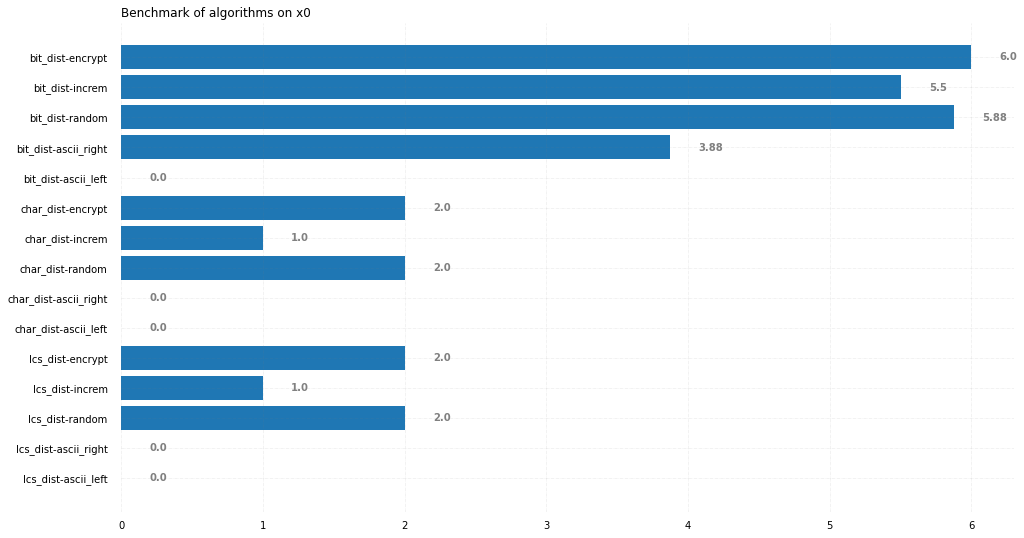

In [ ]:
x0 = "drjdplsj"
delta = 0
max_iter = 5000
best_results, best_names = benchmark_x0(x0, delta, max_iter)
best_results = normalize(best_results, best_names, len(x0))
plot_horizontal_histogram(best_results, best_names, "Benchmark of algorithms on x0")

### Benchmark x0 on 32 Bytes
Pretty much the same results as for 8 bytes, except better results with ascii translations.

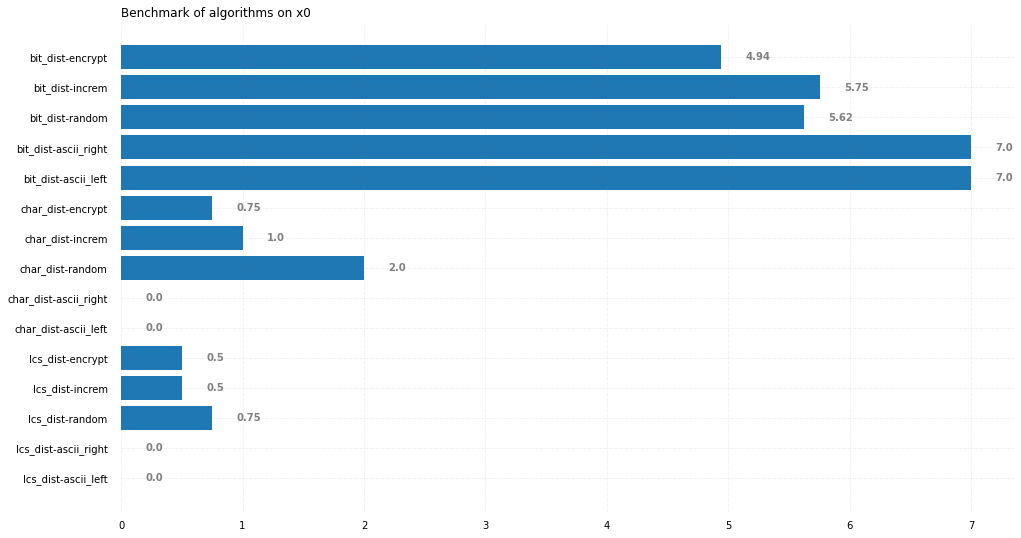

In [ ]:
x0 = "aurponfhskdloieyrhtnshqkzpelrmqa"
delta = 0
max_iter = 5000
best_results, best_names = benchmark_x0(x0, delta, max_iter)
best_results = normalize(best_results, best_names, len(x0))
plot_horizontal_histogram(best_results, best_names, "Benchmark of algorithms on x0")

### Benchmark on the key
This is where we confirm that we found a pattern when using the key.

In [ ]:
def benchmark_key(x0: str, key: str, delta: int, max_iter: int):
    """
    Use floyd_with_key() on all possible combinations of distance 
    and iterative functions.
    """
    distance_funcs = {
        'bit_dist': bit_distance,
        'char_dist': char_distance,
        'lcs_dist': lcs_distance,
    }
    iterative_funcs = {
        'encrypt': f,
        'increm': f_str_increm_no_double,
        'random': f_str_rand,
        'ascii_right': f_str_ascii_right_increment,
        'ascii_left': f_str_ascii_left_increment,
    }
    histograms = []

    for dist_str, dist in distance_funcs.items():
        for ite_str, ite in iterative_funcs.items():
            operation_str = f'{dist_str}-{ite_str}'
            hist = floyd_with_key(dist, ite, x0, key, delta, max_iter, False)
            histograms.append((operation_str, hist))

    def get_default_value(name, x0):
        return len(x0) if name.find('bit') == -1 else len(x0)**2

    best_results = [min(hist, default=get_default_value(name, x0)) \
        for name, hist in histograms]
    best_names = [name for name, _ in histograms]
    return (best_results, best_names)

We found a patern for:  
- bit distance with random generation
- char distance with random generation
- lcs with random generation  

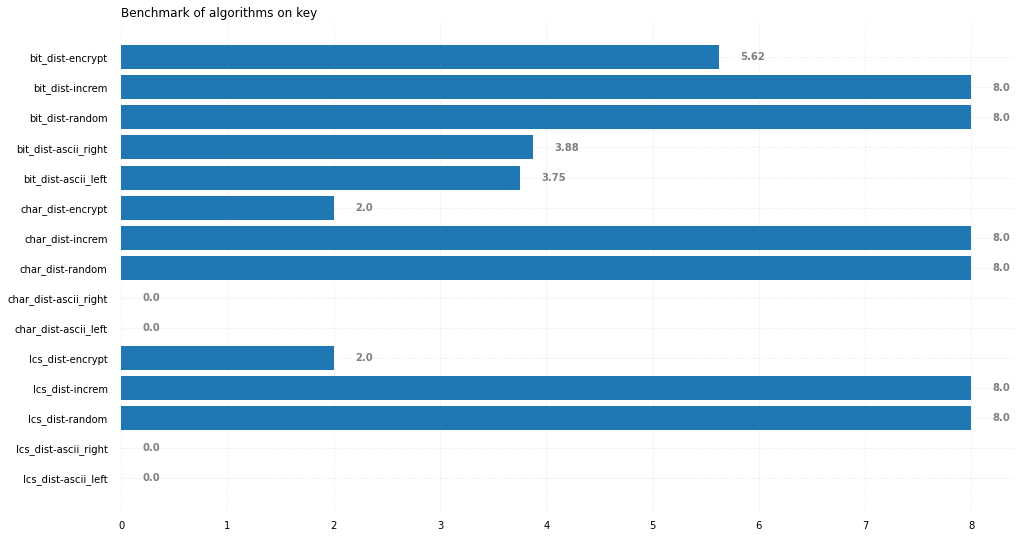

In [ ]:
delta = 0
x0 = "vncbzpls"
key = "orituhsk"
max_iter = 3000
best_results, best_names = benchmark_key(x0, key, delta, max_iter)
best_results = normalize(best_results, best_names, len(key))
plot_horizontal_histogram(best_results, best_names, "Benchmark of algorithms on key")

## V. Conclusion
#### Pattern 1 (found a cycle for nb_turns=2)
Using floyd algorithm we found a cycle in 7 iterations for the strings xyxyxyxy, xxxxxxxx, yxyxyxyx...

#### Pattern 2 (key):  
We found that we can generate the same encrypted value for three similar input strings, and sometimes more.  
```
  k: str
  DES('abab...ab').encrypt(k) => X
  DES('acac...ac').encrypt(k) => X
  DES('bbbb...bb').encrypt(k) => X
```
However,
```
  DES('adad...ad').encrypt(k) => Y != X
  DES('cbcb...cb').encrypt(k) => Y != X
```
In some cases (not always), this pattern also works:
```
  DES('abab...ab').encrypt(k) => X
  DES('bcbc...bc').encrypt(k) => X
  (ex: xpxpxpxp and yqyqyqyq)
```
So for any given key *k*, we can find two keys that will give the same encrypted value, and in some cases three.  

#### Pattern 3 (data):  
We also found that for a key using only a succession of the same character of 2 alphabet consecutive characters (ex: aeeaaaae, dddddddd), we can generate 2^n substitutions that will produce the same output (with n = length of message).
```
  DES(key).encrypt('dddddddd') => X
  DES(key).encrypt('cccccccc') => X
  DES(key).encrypt('dcdcdcdc') => X
  DES(key).encrypt('ddddcccc') => X
  ...
```


### POC: pattern found in key encryption

In [ ]:
x0 = "yhtmlsrguipdbnqj"
pairs = {
    "abababab": "acacacac",
    "bcbcbcbc": "cccccccc",
    "xpxpxpxp": "yqyqyqyq",
}

for k, v in pairs.items():
    algo = des(k)
    a = algo.encrypt(x0)
    algo = des(v)
    b = algo.encrypt(x0)

    assert bit_distance(a, b) == 0
    assert a == b

### POC: pattern found in data

In [ ]:
def chain_cipher(key):
    """
    Returns a list of 5 chained encryption using `key`.
    """
    x0 = "yhtmlsrguipdbnqj"
    k = des(key)
    res = []
    for _ in range(5):
        x0 = k.encrypt(x0)
        res.append(x0)
    return res

a = chain_cipher("dddddddd")
b = chain_cipher("eeeeeeee")
c = chain_cipher("edddddde")
d = chain_cipher("eeedeeed")
e = chain_cipher("edddeddd")

assert a == b == c == d == e